In [1]:
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os, json, pickle, torch
from scipy.stats import gaussian_kde
import seaborn as sns
from pathlib import Path

plt.rcParams['font.size'] = 13

In [2]:
def get_output(root, tag, summary=False, fmt='n_{:03d}', epoch='best',
               dataset=['train','valid','test'], verbose=False):
    output = {ds:[] for ds in dataset}
    path = os.path.join(root, tag)
    if not os.path.isdir(path):
        return output
    for i in range(100):
        dn = os.path.join(path, fmt.format(i))
        for ds in dataset:
            dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
            if not os.path.isfile(dfn): 
                continue
            with open(dfn, 'rb') as f:
                ids, tgts, preds = pickle.load(f)
            o = np.argsort(ids)
            ids = ids[o]
            tgts = tgts[o]
            preds = preds[o]
            output[ds].append([ids, tgts, preds])
    if verbose:
        ps =  [f'{tag:8s} //' + ''.join([f'{ds:>12} (R2/RMSE/MAE) //' for ds in dataset])]
        ps += [f'Fold: {k:2d} // ' for k in range(len(output['train']))]
        ps += ['AVG:     // ']
        ps += ['STD:     // ']
        ps += ['ALL:     // ' + '        /'*3 + '/ ']
        for i, (ds, d1) in enumerate(output.items()):
            ms = []
            for j, (_, t, p) in enumerate(d1):
                ms.append([r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p)])
                ps[j+1] += '{:7.3f} / {:6.2f} / {:6.2f} // '.format(*ms[-1])
            avg = np.mean(ms, axis=0)
            std = np.std(ms, axis=0)
            ps[-3] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(*avg)
            ps[-2] += ' ±{:5.3f} / ±{:5.2f} / ±{:5.2f} // '.format(*std)
            if ds == 'valid':
                t, p = np.vstack([np.hstack([t, p]) for _, t, p in d1]).T
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
            elif ds == 'test':
                t = d1[0][1]
                p = np.median(np.hstack([p for _, t, p in d1]), axis=1)
                ps[-1] += ' {:6.3f} / {:6.2f} / {:6.2f} // '.format(r2_score(t, p), np.sqrt(mean_squared_error(t, p)), mean_absolute_error(t, p))
        print(ps[0])
        print('-'*len(ps[1]))
        if not summary:
            for p in ps[1:-3]:
                print(p)
            print('-'*len(ps[1]))
        print(ps[-3])
        print(ps[-2])
        print(ps[-1])
    return output

In [4]:
metric = ['R2']
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs'
nets = ['mol','graph','concat']
cv_errs = {
    'train':{'r2':[],'rmse':[],'mae':[]},
    'valid':{'r2':[],'rmse':[],'mae':[]},
    'test':{'r2':[],'rmse':[],'mae':[]},
}
for net in nets:
    path = os.path.join(root, net)
    if not os.path.isdir(path): continue
    for tag in sorted(os.listdir(path)):
        output = get_output(path, tag, fmt='cv_{:04d}', epoch='00500')
        path_tag = os.path.join(path, tag)
        print(path_tag)
        for ds in ['train','valid','test']:
            out = output[ds]
            errs = []
            for _, ts, ps in out:
                err = []
                for t, p in zip(ts.T, ps.T):
                    err.append([
                        r2_score(t, p), 
                        np.sqrt(mean_squared_error(t, p)), 
                        mean_absolute_error(t, p)])
                errs.append(err)
            if len(errs) == 0: continue
            sd = torch.load(os.path.join(path_tag, 'cv_0000/00100.model.torch'), map_location='cpu')
            n = np.sum([np.prod(v.cpu().numpy().shape) for k,v in sd.items() if k.startswith('encoder')])
            r2, rmse, mae = np.array(errs).transpose(2, 1, 0)
            cv_errs[ds]['r2'].append([r2, f'{net}_{tag}_{n}'])
            cv_errs[ds]['rmse'].append([rmse, f'{net}_{tag}_{n}'])
            cv_errs[ds]['mae'].append([mae, f'{net}_{tag}_{n}'])
            for s, val in zip(['R2','RMSE','MAE'], [r2, rmse, mae]):
                if s not in metric: continue
                avg = np.mean(val, axis=1)
                std = np.std(val, axis=1)
                print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f} ±{e:.3f}' for v, e in zip(avg, std)]))
            
            fn = os.path.join(path_tag, f'00500.{ds}.pkl')
            if not os.path.isfile(fn): continue
            out = read_data(fn)
            err = []
            for t, p in zip(out['target'].T, out['pred'].T):
                err.append([
                    r2_score(t, p), 
                    np.sqrt(mean_squared_error(t, p)), 
                    mean_absolute_error(t, p)])
            r2, rmse, mae = np.array(err).T
            for s, e in zip(['R2','RMSE','MAE'], [r2, rmse,mae]):
                if s not in metric: continue
                print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f}       ' for v in e]))

/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs/mol/dnn_128_1
train 	 R2 	/   0.689 ±0.011 /  0.984 ±0.001 /  0.902 ±0.005 /  0.972 ±0.001 /  0.955 ±0.002 /  0.960 ±0.001 /  0.999 ±0.000 /  0.992 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000
train 	 R2 	/   0.691        /  0.985        /  0.905        /  0.974        /  0.958        /  0.961        /  0.999        /  0.992        /  1.000        /  1.000        /  1.000        /  1.000       
valid 	 R2 	/   0.652 ±0.010 /  0.981 ±0.004 /  0.889 ±0.004 /  0.968 ±0.001 /  0.947 ±0.003 /  0.957 ±0.001 /  0.999 ±0.000 /  0.988 ±0.006 /  0.999 ±0.002 /  0.999 ±0.002 /  0.999 ±0.002 /  0.999 ±0.002
test 	 R2 	/   0.666 ±0.009 /  0.987 ±0.000 /  0.897 ±0.004 /  0.969 ±0.001 /  0.952 ±0.002 /  0.963 ±0.001 /  0.999 ±0.000 /  0.992 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000 /  1.000 ±0.000
test 	 R2 	/   0.681        /  0.988        /  0.901        /  0.971        /  0.956        /  0.964        /  0.

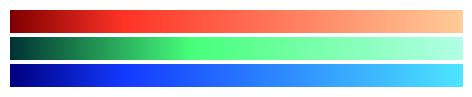

In [21]:
cmap1 = lambda x: [np.min([x*2+0.5,1]), x*0.8, x*0.6]
cmap2 = lambda x: [x*0.7, np.min([x*2+0.2,1]), np.min([x*0.7+0.2, 1])]
cmap3 = lambda x: [x*0.3, x*0.9, np.min([x*2+0.5, 1])]
f, axs = plt.subplots(3,1,figsize=(10,1))
for ax, cmap in zip(axs, [cmap1, cmap2, cmap3]): 
    ax.imshow([[cmap(x) for x in np.linspace(0,1,500)]], extent=[0,200,0,10])
    ax.axis('off')

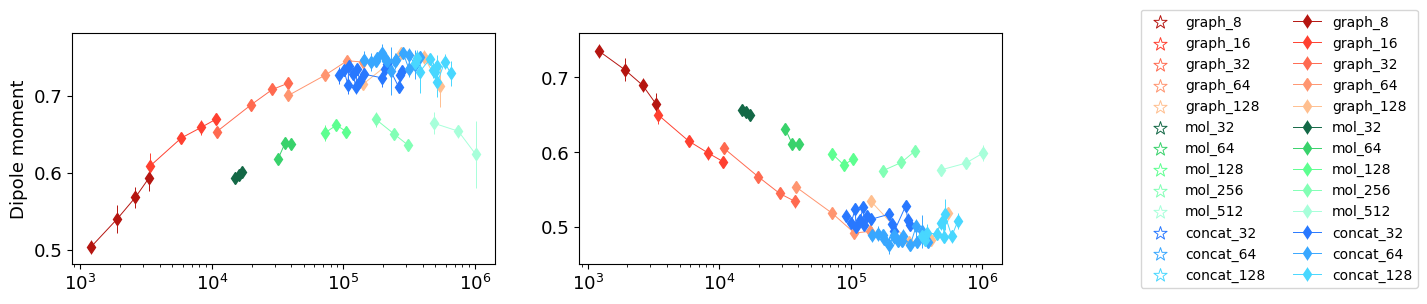

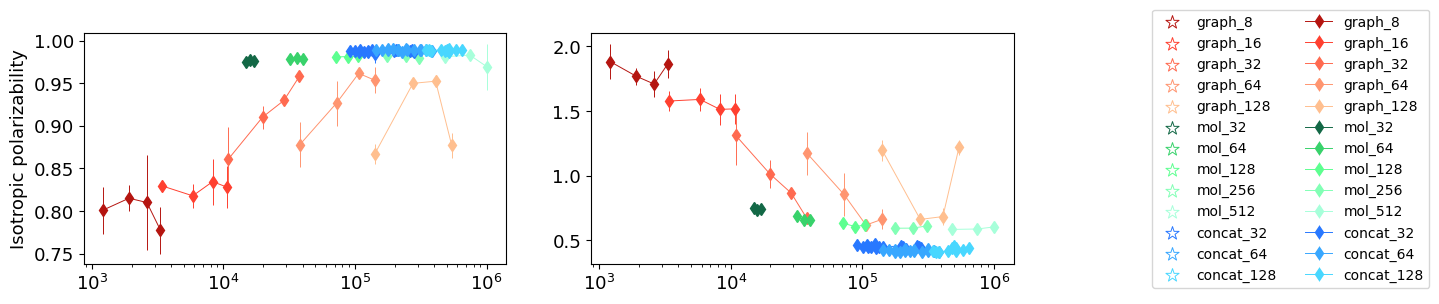

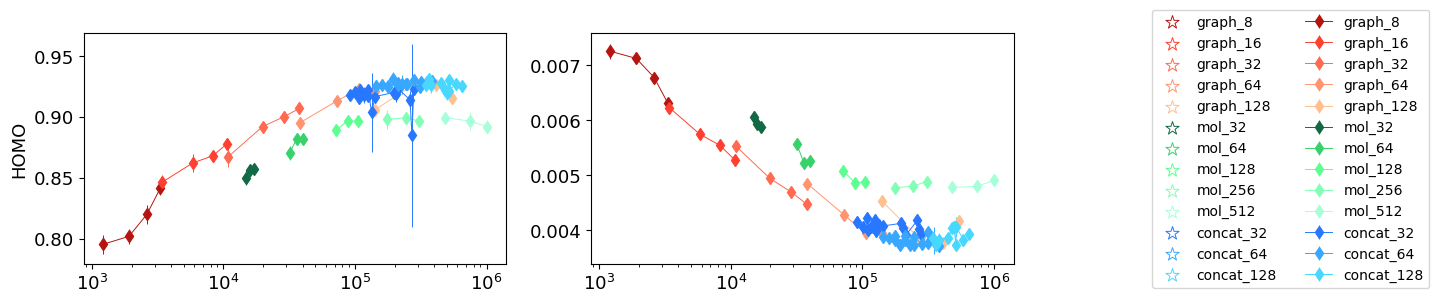

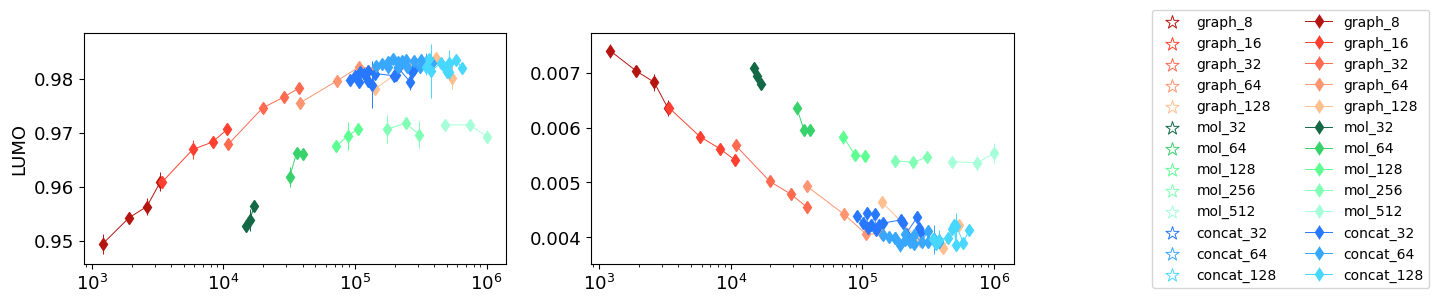

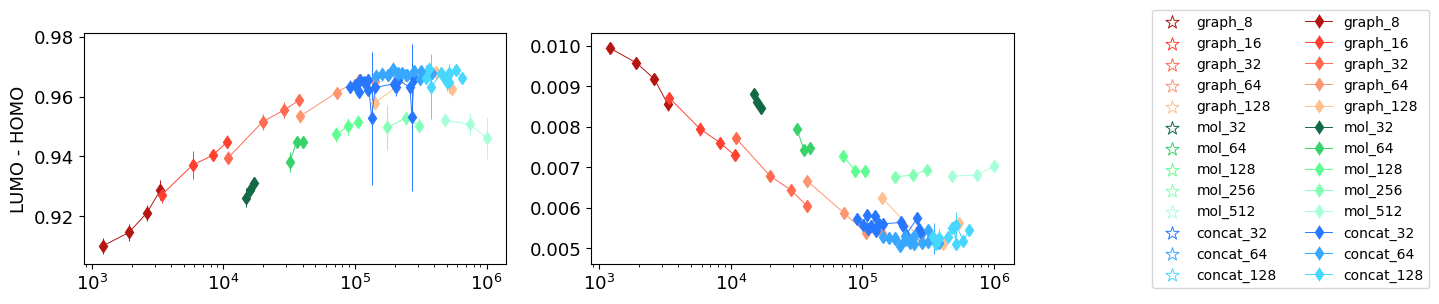

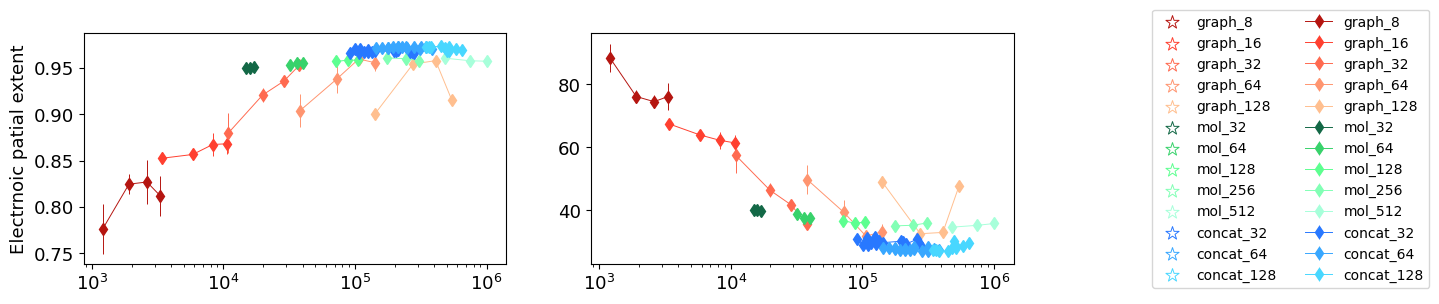

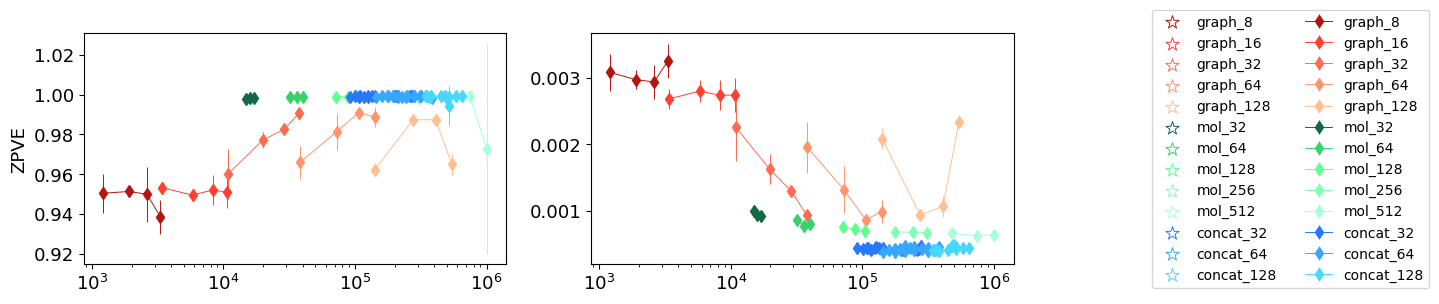

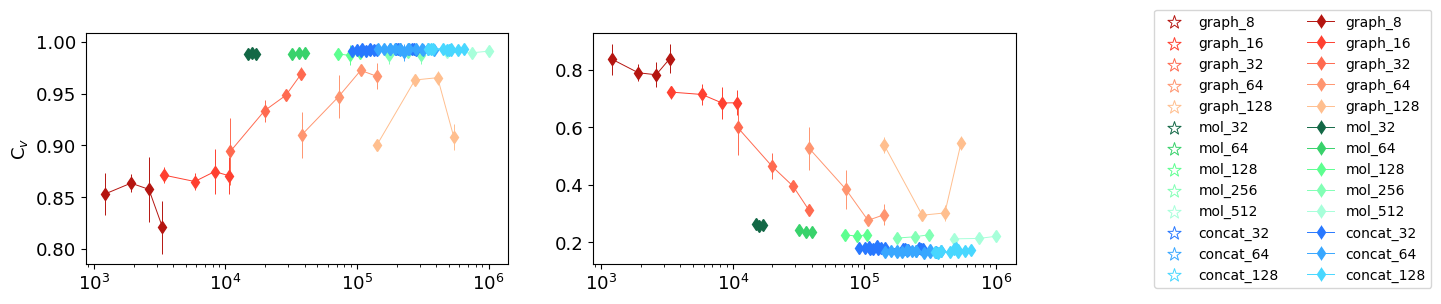

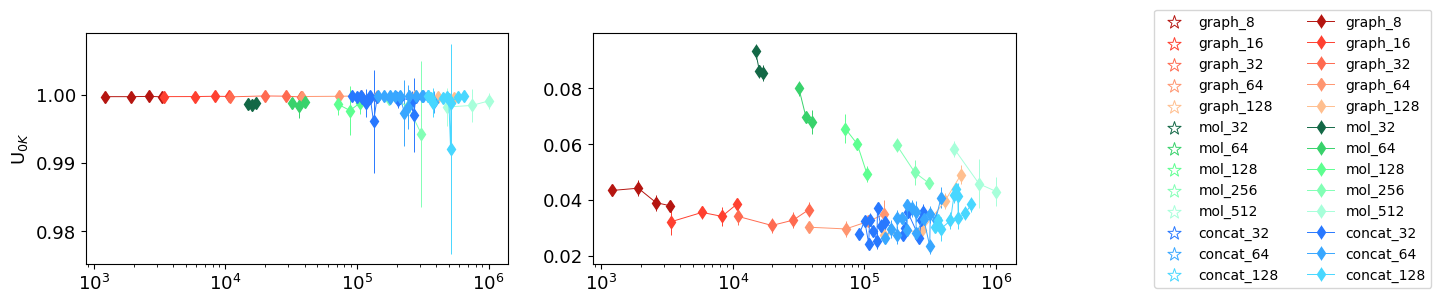

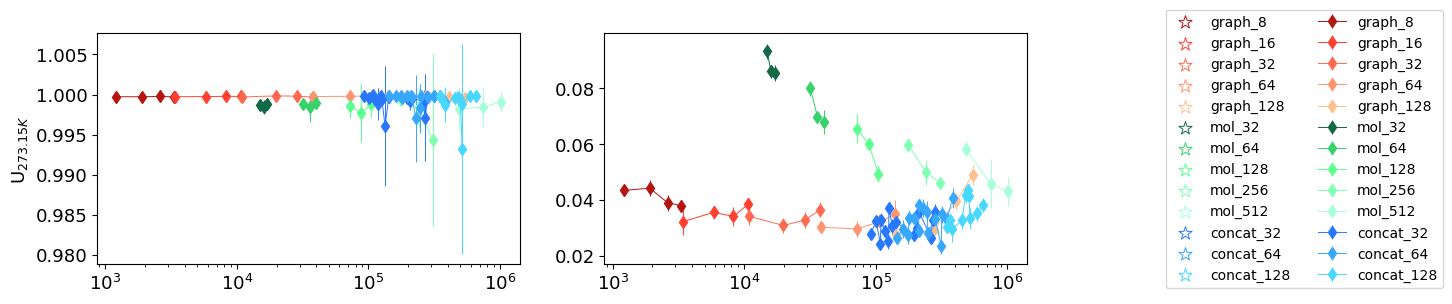

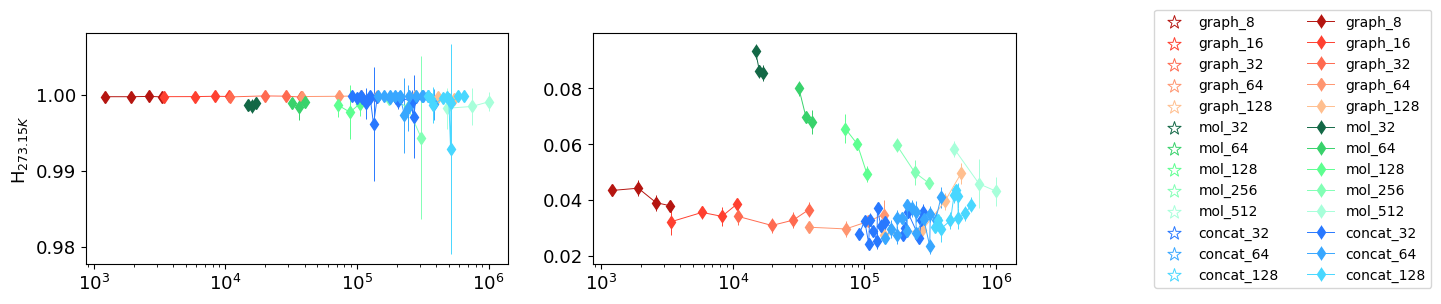

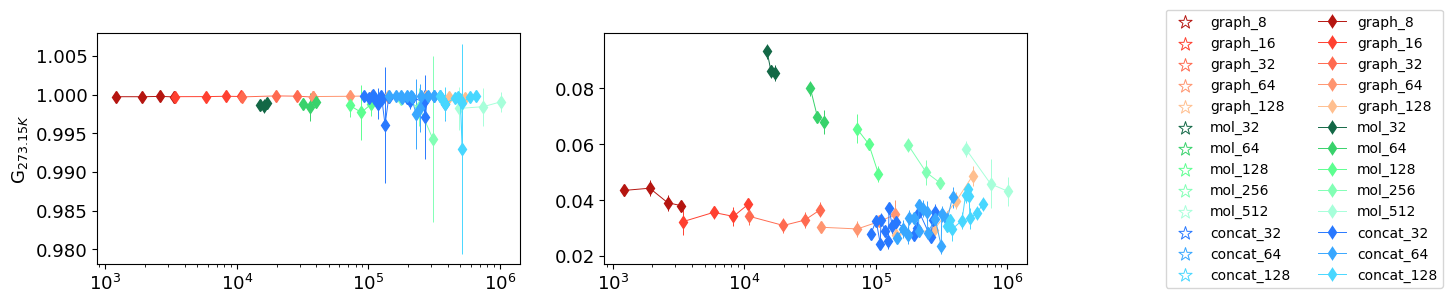

In [22]:
xlbl = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
metrics = ['r2','mae']
by_node = True
by_graph = True
figs = {lbl:plt.subplots(1,len(metrics),figsize=(12,3)) for lbl in xlbl}
for ds in ['valid']:
    for i, metric in enumerate(metrics):
        err = sorted(cv_errs[ds][metric], key=lambda x: float(x[1].split('_')[4]))
        lbls = np.array([e[1] for e in err])
        x = np.array([float(l.split('_')[4]) for l in lbls])
        yss = np.array([np.mean(e[0], axis=1) for e in err])
        ers = np.array([np.std(e[0], axis=1) for e in err])
        group = np.array([l.split('_')[3-int(by_node)].split('.')[int(by_graph)-1] for l in lbls]).astype(float)
        for j, (ys, er) in enumerate(zip(yss.T, ers.T)):
            for net in ['graph','mol','concat']:
                if net == 'graph':
                    cmap = lambda x: cmap1((x-3+0.5)/4.8) if by_node else cmap1((x-2+0.5)/6.8)
                elif net == 'mol':
                    cmap = lambda x: cmap2((x-5+0.5)/4.8) if by_node else cmap2((x-1+0.5)/2.8)
                else:
                    if by_graph:
                        cmap = lambda x: cmap3((x-3+0.5)/4.8) if by_node else cmap3((x-2+0.5)/6.8)
                    else:
                        cmap = lambda x: cmap3((x-5+0.5)/4.8) if by_node else cmap3((x-1+0.5)/2.8)
                for nl in range(1,10):
                    p = 2 ** nl if by_node else nl
                    mask = np.array([l.startswith(net) and int(g) == p for l,g in zip(lbls, group)])
                    mask = mask & np.array(['old' not in l for l in lbls])
                    if np.sum(mask) == 0: continue
#                    print(net, p, nl, cmap(nl))
                    figs[xlbl[j]][1][i].errorbar(x[mask], y=ys[mask], lw=0.7, fmt='--' if ds =='train' else '-', yerr=er[mask], marker='s' if ds == 'train' else 'd', color=cmap(nl), label=f'{net}_{p}')

                    mask = np.array([l.startswith(net) and 'old' in l for l in lbls])
                    figs[xlbl[j]][1][i].scatter(x[mask], y=ys[mask], lw=0.7, marker='*', facecolor=[1,1,1], edgecolor=cmap(nl), label=f'{net}_{p}', s=100)

for lbl, (f, ax) in figs.items():
    ax[0].set_ylabel(lbl)
    ax[-1].legend(loc='center right', bbox_to_anchor=[2, 0.5], fontsize=10, ncol=2)
    for _ax in ax:
#        _ax.set_xlim([8e2, 2e6])
        _ax.set_xscale('log')


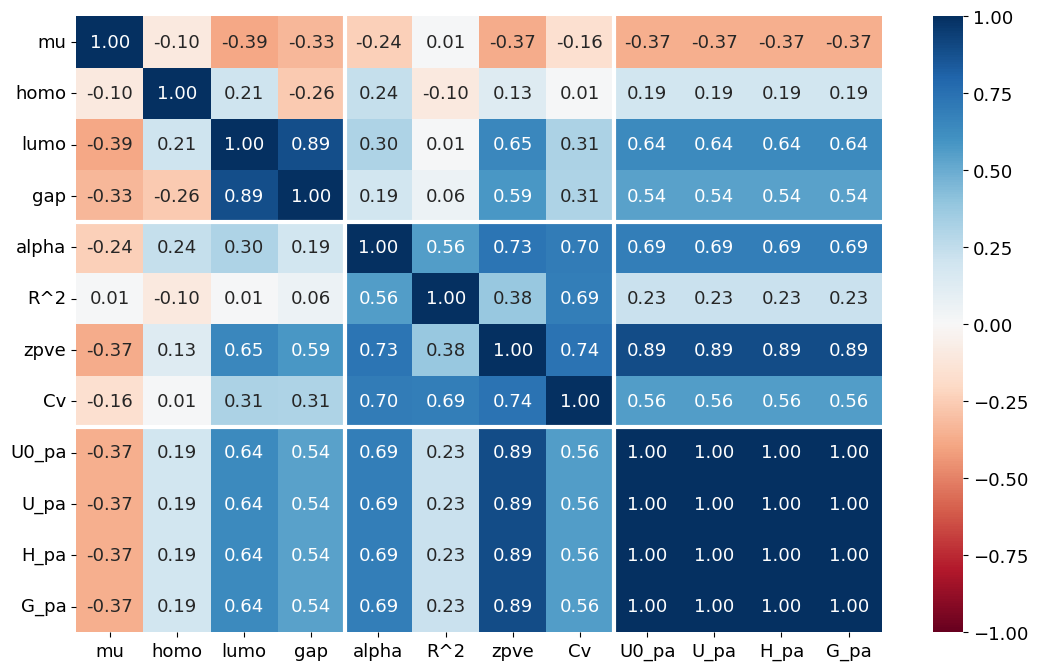

In [688]:
import seaborn as sns

#df = pd.read_csv('./package/dataset/qm9.csv')
cols = ['mu', 'homo', 'lumo', 'gap', 'alpha', 'R^2', 'zpve', 'Cv', 'U0_pa', 'U_pa', 'H_pa', 'G_pa']
f, ax = plt.subplots(1,1,figsize=(13,8))
sns.heatmap(df[cols].corr().values, ax=ax, vmin=-1, vmax=1, cmap='RdBu', annot=True, fmt='.2f')
_ = ax.set_xticklabels(cols)
_ = ax.set_yticklabels(cols, rotation=0)
for i in [4, 8]:
    ax.axvline(i, color=[1,1,1], lw=3)
    ax.axhline(i, color=[1,1,1], lw=3)

G$_{273.15K}$


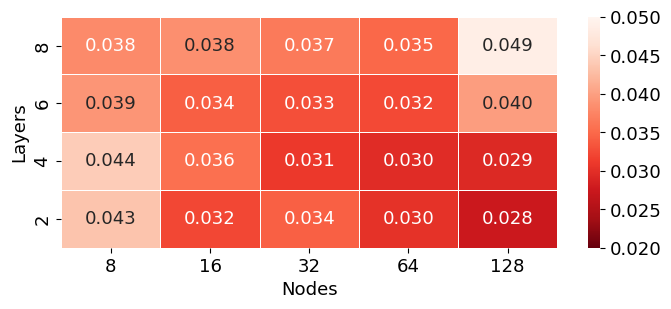

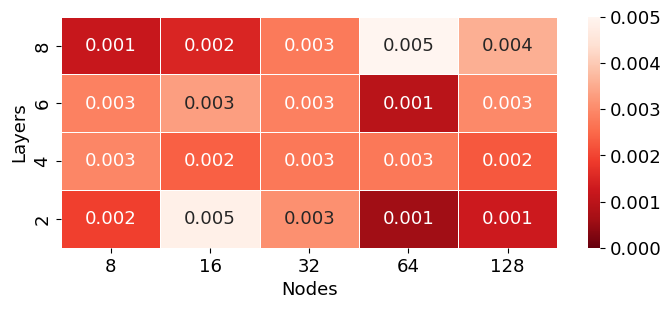

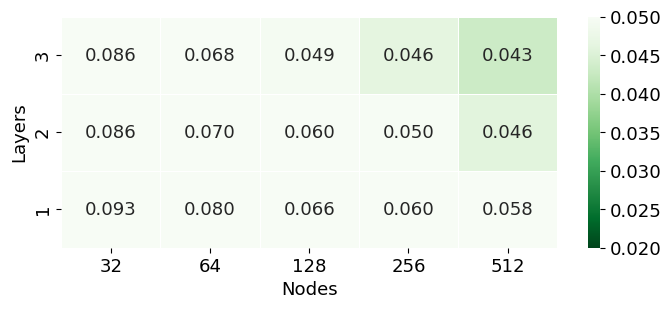

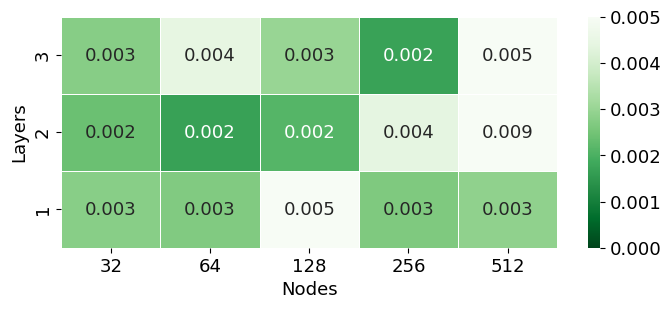

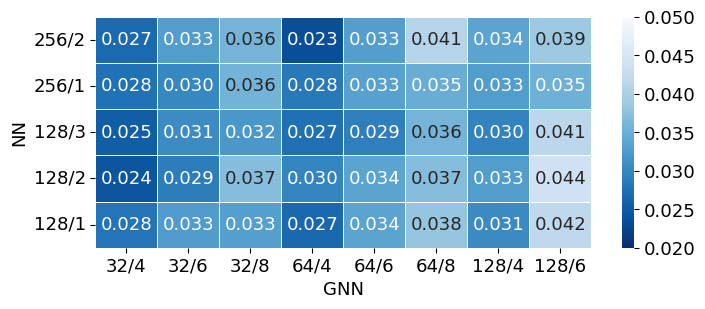

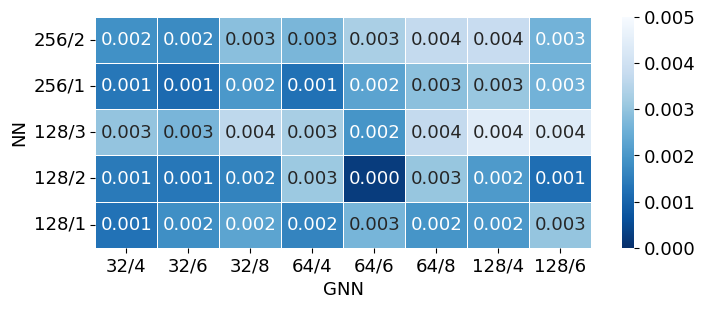

In [28]:
metric = 'mae'
tgts = np.vstack([np.mean(e[0], axis=1) for e in cv_errs['valid'][metric]]).T
errs = np.vstack([np.std(e[0], axis=1) for e in cv_errs['valid'][metric]]).T
xlbls = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
lbls = np.array([e[1] for e in cv_errs['valid'][metric]])
nets = [l.split('_')[0] for l in lbls]
nodes = [int(l.split('_')[2]) if not l.startswith('concat') else 0 for l in lbls]
layers = [int(l.split('_')[3]) if not l.startswith('concat') else 0 for l in lbls]
cnodes = ['/'.join(np.array(l.replace('.','_').split('_'))[[2,4]]) if l.startswith('concat') else '' for l in lbls]
clayers = ['/'.join(np.array(l.replace('.','_').split('_'))[[3,5]]) if l.startswith('concat') else '' for l in lbls]
df_dict = {'Network':nets, 'Nodes':nodes, 'Layers':layers, 'GNN':cnodes, 'NN':clayers}
df_dict.update({f'{k}/avg':v for k,v in zip(xlbls, tgts)})
df_dict.update({f'{k}/std':v for k,v in zip(xlbls, errs)})
mdf = pd.DataFrame(df_dict)
cdf = mdf[mdf.Network == 'concat']

vmins = 0.02, 0.0
vmaxs = 0.05, 0.005
for xlb in xlbls:
    if not xlb.startswith('G'): continue
    print(xlb)
    for net, cmap in zip(['graph','mol','concat'], ['Reds_r','Greens_r','Blues_r']):
        for tgt, vmin, vmax in zip(['avg','std'], vmins, vmaxs):
            f, ax = plt.subplots(1, 1, figsize=(8, 3))
            if net =='concat':
                cdf_p = pd.pivot(cdf, index='NN', columns='GNN', values=f'{xlb}/{tgt}').T.sort_index(key=lambda x: x.map(lambda x: float(x.split('/')[0]))).T
                sns.heatmap(cdf_p, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt='.3f', linewidth=0.5, ax=ax)       
            else:
                sns.heatmap(pd.pivot(mdf[mdf.Network == net], index='Layers', columns='Nodes', values=f'{xlb}/{tgt}'), 
                            vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt='.3f', linewidth=0.5, ax=ax)       
            ax.invert_yaxis()

In [8]:
metric = ['R2']
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs'
nets = ['mol','graph','concat']
fin_errs = {
    'train':{'r2':[],'rmse':[],'mae':[]},
    'valid':{'r2':[],'rmse':[],'mae':[]},
    'test':{'r2':[],'rmse':[],'mae':[]},
}
for net in nets:
    path = os.path.join(root, net)
    if not os.path.isdir(path): continue
    for tag in sorted(os.listdir(path)):
        path_tag = os.path.join(path, tag)
        for ds in ['train','test']:
            fn = os.path.join(path_tag, f'00500.{ds}.pkl')
            if not os.path.isfile(fn): continue
            out = read_data(fn)
            ts = out['target']
            ps = out['pred']
            err = []
            for t, p in zip(ts.T, ps.T):
                err.append([
                    r2_score(t, p), 
                    np.sqrt(mean_squared_error(t, p)), 
                    mean_absolute_error(t, p)])
            sd = torch.load(os.path.join(path_tag, '00100.model.torch'), map_location='cpu')
            n = np.sum([np.prod(v.cpu().numpy().shape) for k,v in sd.items() if k.startswith('encoder')])
            r2, rmse, mae = np.array(err).T
            fin_errs[ds]['r2'].append([r2, f'{net}_{tag}_{n}'])
            fin_errs[ds]['rmse'].append([rmse, f'{net}_{tag}_{n}'])
            fin_errs[ds]['mae'].append([mae, f'{net}_{tag}_{n}'])
            for s, e in zip(['R2','RMSE','MAE'], [r2, rmse,mae]):
                if s not in metric: continue
                print(net, tag, '\t', n, ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f}' for v in e]))

mol dnn_128_1 	 71840 train 	 R2 	/   0.691 /  0.985 /  0.905 /  0.974 /  0.958 /  0.961 /  0.999 /  0.992 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_128_1 	 71840 test 	 R2 	/   0.681 /  0.988 /  0.901 /  0.971 /  0.956 /  0.964 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_128_2 	 88352 train 	 R2 	/   0.727 /  0.986 /  0.918 /  0.977 /  0.962 /  0.963 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_128_2 	 88352 test 	 R2 	/   0.689 /  0.989 /  0.906 /  0.974 /  0.959 /  0.964 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_128_3 	 104864 train 	 R2 	/   0.756 /  0.987 /  0.923 /  0.979 /  0.965 /  0.963 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_128_3 	 104864 test 	 R2 	/   0.692 /  0.987 /  0.909 /  0.974 /  0.959 /  0.963 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000
mol dnn_256_1 	 176416 train 	 R2 	/   0.758 /  0.987 /  0.925 /  0.980 /  0.966 /  0.966 /  0.999 /  0.993 /  1.000 /  1.000 /  1.000 /  1.000

(800.0, 2000000.0)

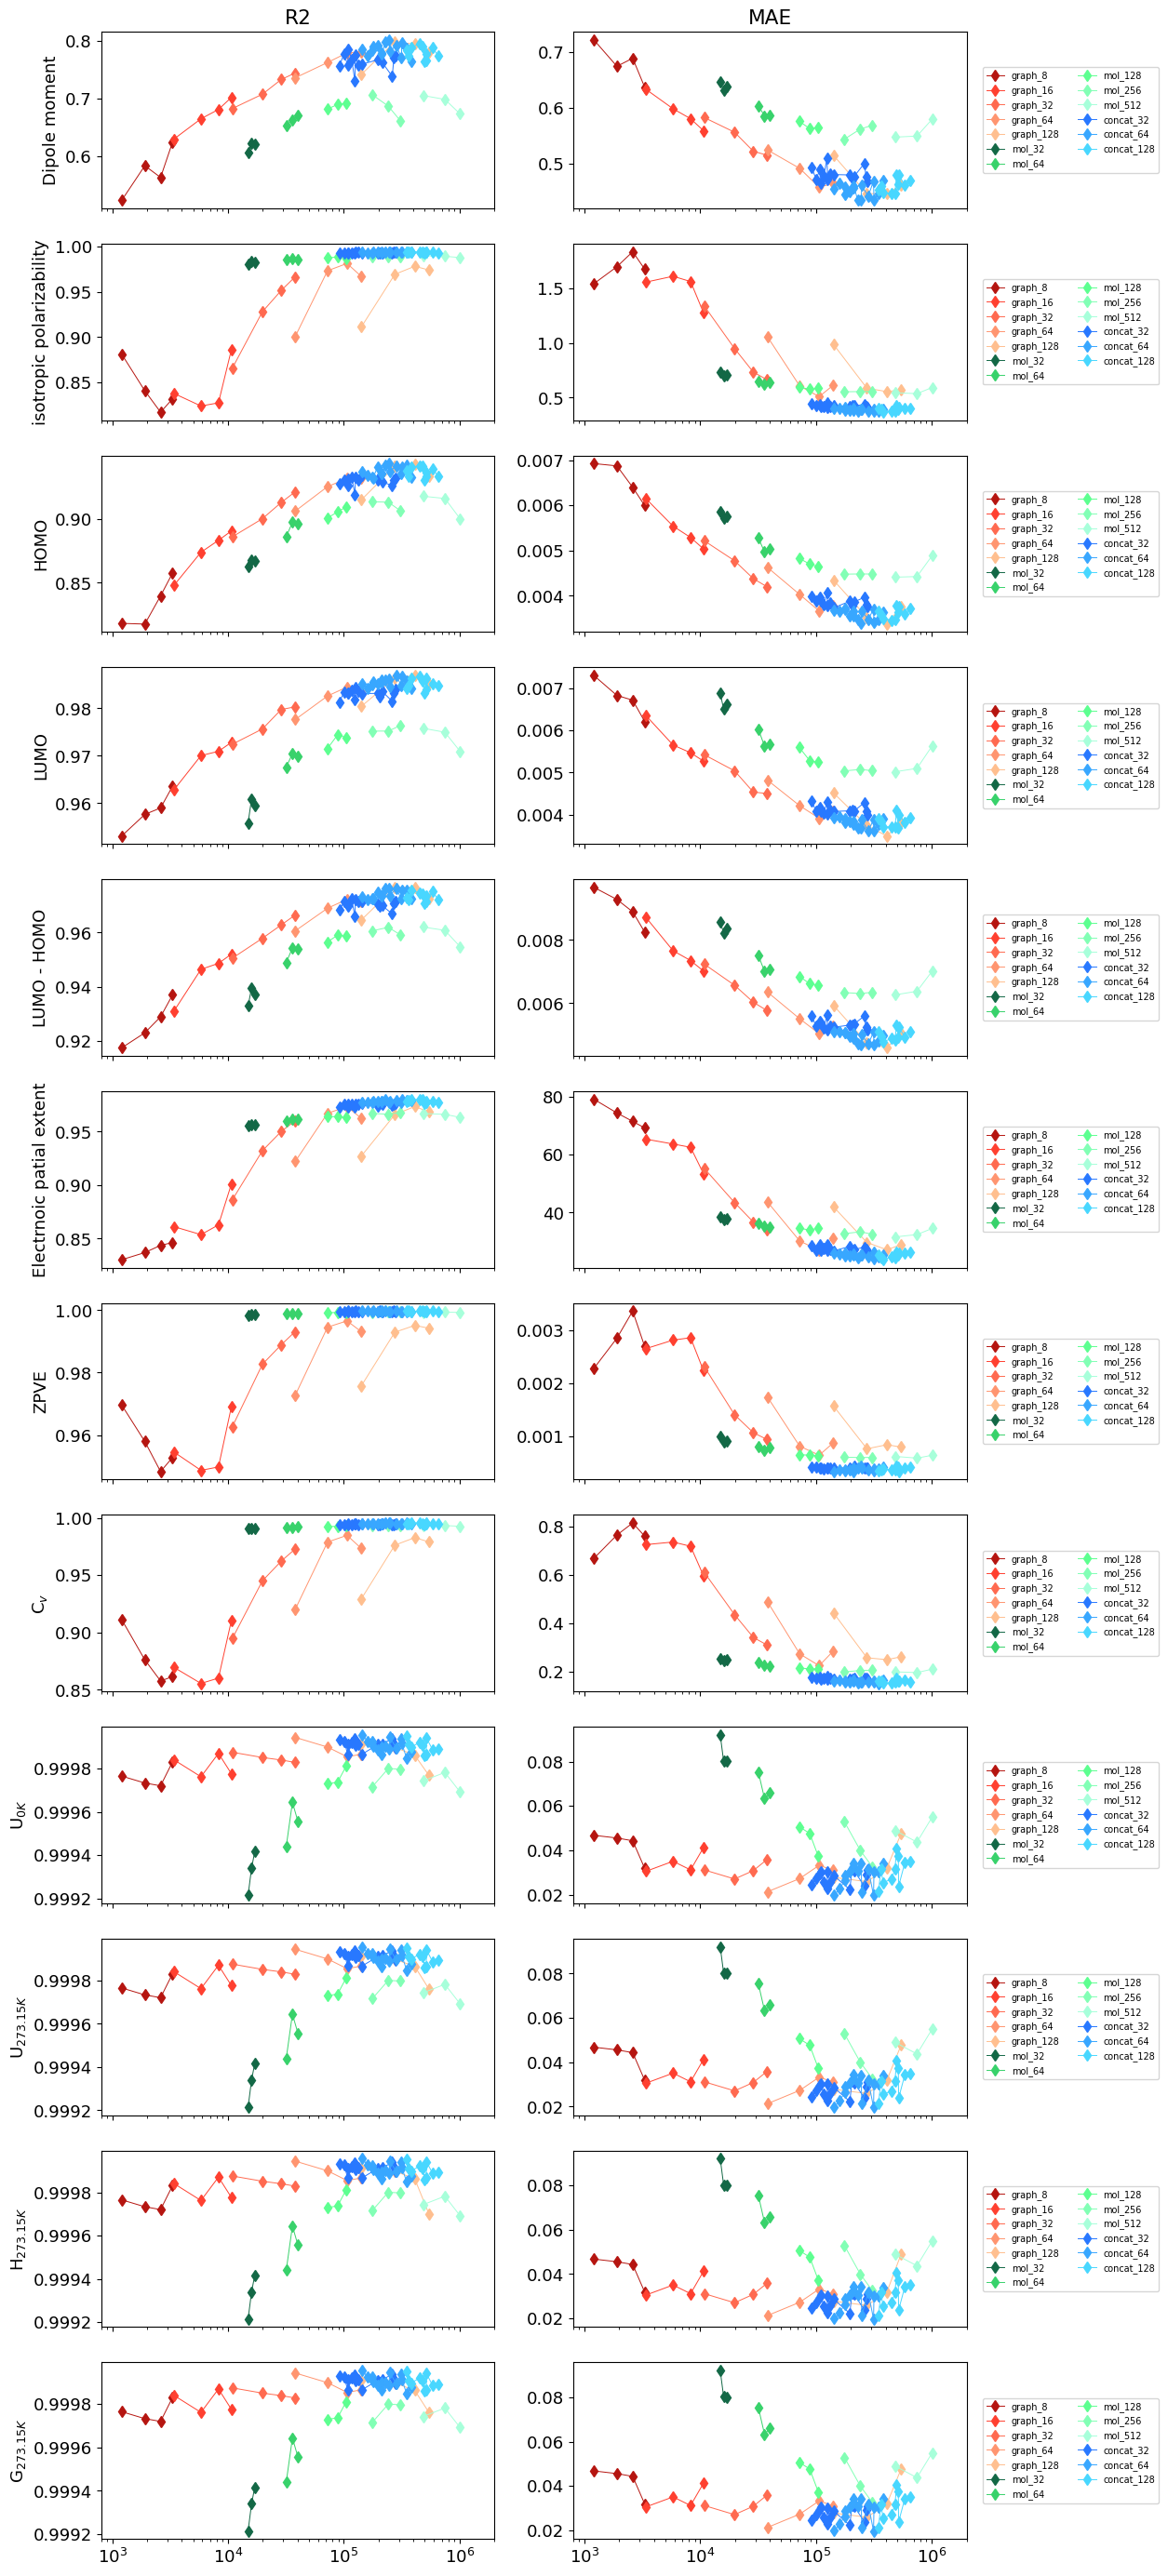

In [9]:
xlbls = ["Dipole moment","isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
f, axs = plt.subplots(12,2,figsize=(12,35), sharex=True)
metrics = ['r2','mae']
by_node = True
by_graph = True
for i, metric in enumerate(metrics):
    for ds in ['test']:
        err = sorted(fin_errs[ds][metric], key=lambda x: float(x[1].split('_')[4]))
        lbls = np.array([e[1] for e in err])
        x = np.array([float(l.split('_')[4]) for l in lbls])
        yss = np.array([e[0] for e in err])
        group = np.array([l.split('_')[3-int(by_node)].split('.')[int(by_graph)-1] for l in lbls]).astype(float)
        for j, ys in enumerate(yss.T):
            for net in ['graph','mol','concat']:
                if net == 'graph':
                    cmap = lambda x: cmap1((x-3+0.5)/4.8) if by_node else cmap1((x-2+0.5)/6.8)
                elif net == 'mol':
                    cmap = lambda x: cmap2((x-5+0.5)/4.8) if by_node else cmap2((x-1+0.5)/2.8)
                else:
                    if by_graph:
                        cmap = lambda x: cmap3((x-3+0.5)/4.8) if by_node else cmap3((x-2+0.5)/6.8)
                    else:
                        cmap = lambda x: cmap3((x-5+0.5)/4.8) if by_node else cmap3((x-1+0.5)/2.8)
                for nl in range(1,10):
                    p = 2 ** nl if by_node else nl
                    mask = np.array([l.startswith(net) and int(g) == p for l,g in zip(lbls, group)])
                    if np.sum(mask) == 0: continue
#                    print(net, p, nl, cmap(nl), x.shape, mask.shape, ys.shape)
                    axs[j, i].errorbar(x[mask], y=ys[mask], lw=0.7, fmt='--' if ds =='train' else '-', 
                                       yerr=np.zeros_like(x[mask]), marker='s' if ds == 'train' else 'd', color=cmap(nl), label=f'{net}_{p}')


for ax, lbl in zip(axs, xlbls):
    ax[1].legend(loc='center right', bbox_to_anchor=[1.5, 0.5], ncol=2, fontsize=7)
    ax[0].set_ylabel(lbl)
axs[0,0].set_title('R2')
axs[0,1].set_title('MAE')
axs[-1,-1].set_xscale('log')
axs[0,0].set_xlim([8e2, 2e6])
#axs[-1,1].set_xticks(list(range(len(xlbl))), labels=xlbl)

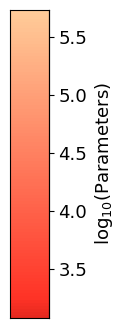

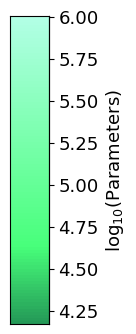

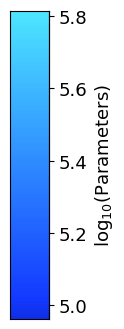

In [334]:
sizes = {m:[np.log10(float(l.split('_')[4])) for l in lbls if l.startswith(m)] for m in 'gmc'}
for cmap, m in zip([cmap1, cmap2, cmap3], 'gmc'):
    f, ax = plt.subplots(1,2,figsize=(0.5,4), gridspec_kw={'width_ratios':[1,0]})
    im = ax[0].pcolormesh([sizes[m]])
    plt.colorbar(im, cax=ax[1])
    ax[0].pcolormesh([[cmap(x)] for x in np.linspace(0.2,1,100)])
    ax[0].set_xlim([0,1])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_ylabel('log$_{10}$(Parameters)')
    f.subplots_adjust(wspace=0)
    

In [321]:
np.array([[cmap(x) for x in np.linspace(0.2,1,100)]]).shape

(1, 100, 3)

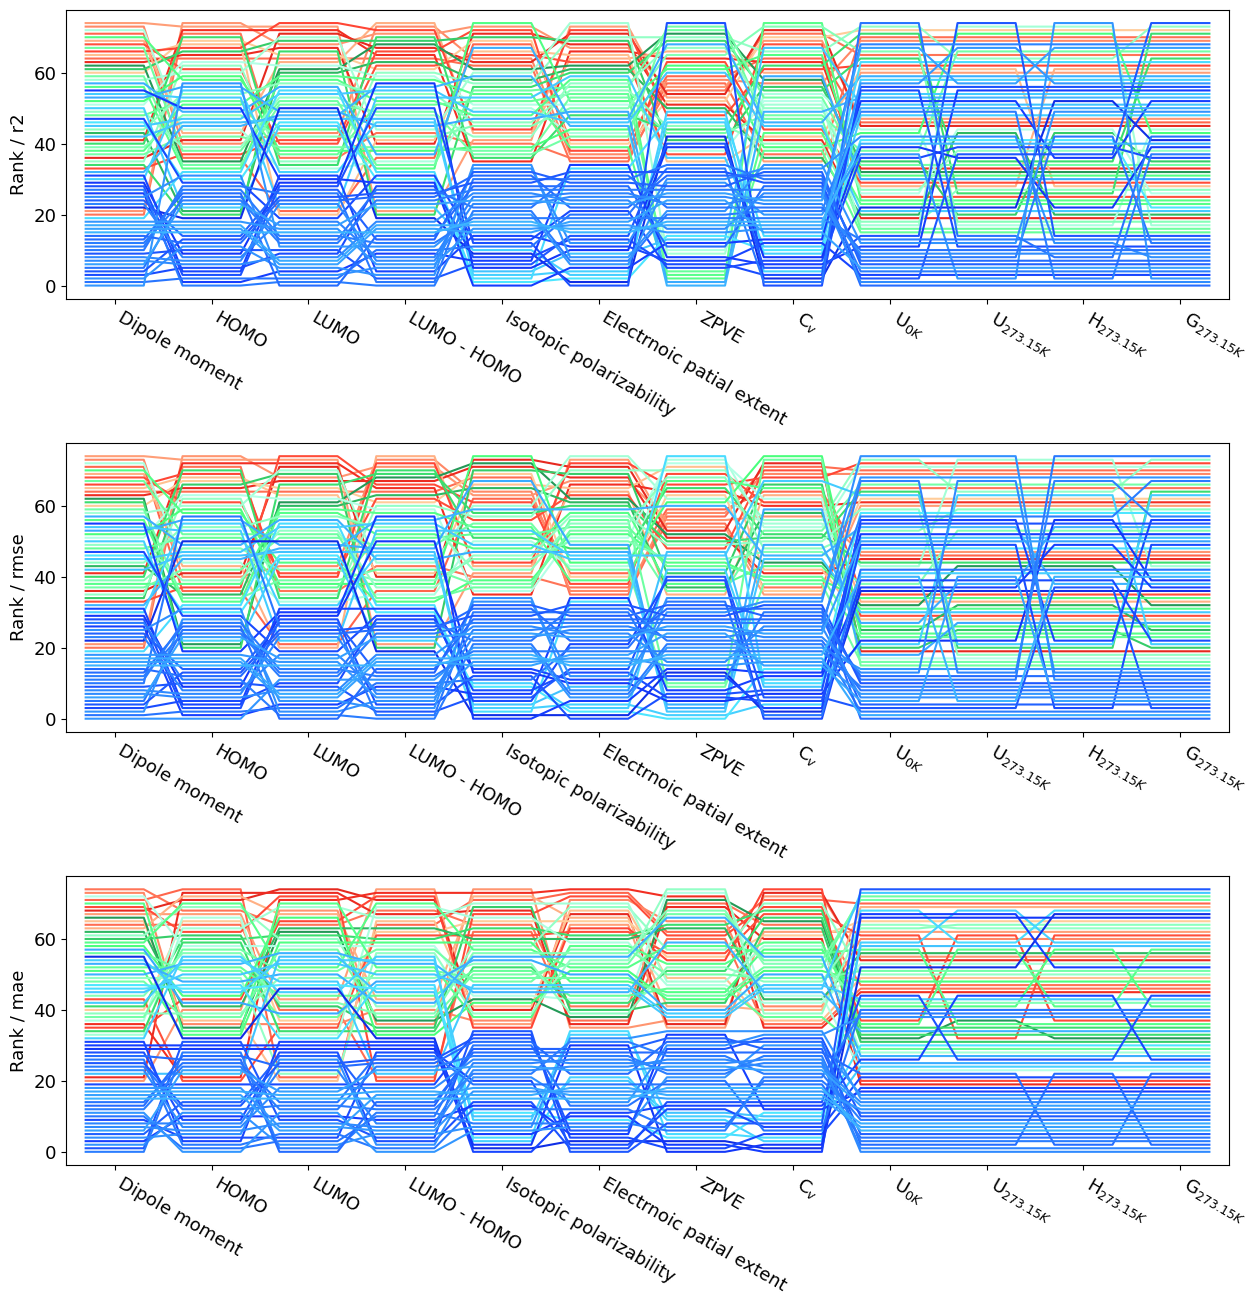

In [259]:
xlbls = ["Dipole moment","HOMO","LUMO","LUMO - HOMO","isotropic polarizability","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
f, axs = plt.subplots(3,1,figsize=(15,15))
for i, (metric, err) in enumerate(cv_errs['valid'].items()):
    ys = np.array([np.mean(e[0], axis=1) for e in err])
    ranks = np.argsort(ys, axis=0) if metric != 'r2' else np.argsort(ys, axis=0)[::-1]
    ranks = np.hstack([ranks[:,0:1], ranks[:, 2:5], ranks[:, 1:2], ranks[:,5:]])
    x = np.hstack([[i-0.3, i+0.3] for i in range(ys.shape[1])])
    lbls = np.array([e[1] for e in err])
    size = np.array([float(l.split('_')[4]) for l in lbls])
    minmax = {m[0]:[np.min([s for s, l in zip(size, lbls) if l.startswith(m)]), np.max([s for s, l in zip(size, lbls) if l.startswith(m)])] for m in ['mol','graph','concat']}
    for y, l, s in zip(ranks, lbls, size):
        yy = np.hstack([[_y, _y] for _y in y])
        vmin, vmax = minmax[l[0]]
        scale = 0.8 * (np.log10(s) - np.log10(vmin))/(np.log10(vmax)  - np.log10(vmin)) + 0.2
        if l.startswith('mol'):
            axs[i].plot(x, yy, label='Global state', color=cmap1(scale))
        elif l.startswith('graph'):
            axs[i].plot(x, yy, label='Graph feature', color=cmap2(scale))
        elif l.startswith('concat'):
            axs[i].plot(x, yy, label='Mixed', color=cmap3(scale))
    axs[i].set_xticks(list(range(len(xlbl))), labels=xlbls, rotation=-30, ha='left')
    axs[i].set_xlim([-0.5, 11.5])
    axs[i].set_ylabel(f'Rank / {metric}')
f.subplots_adjust(hspace=0.5)

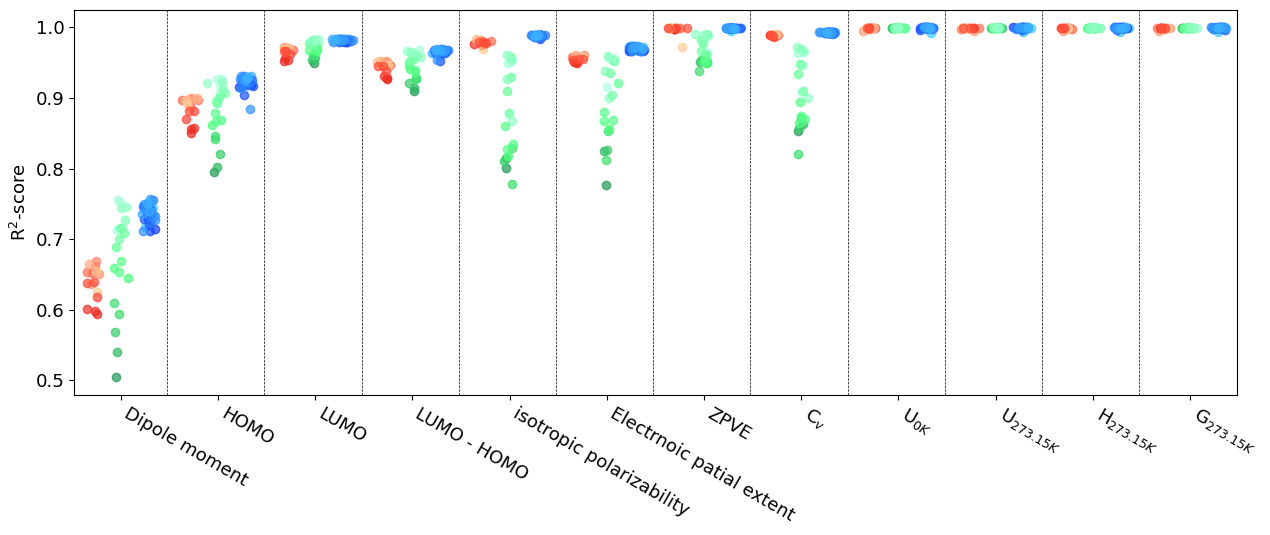

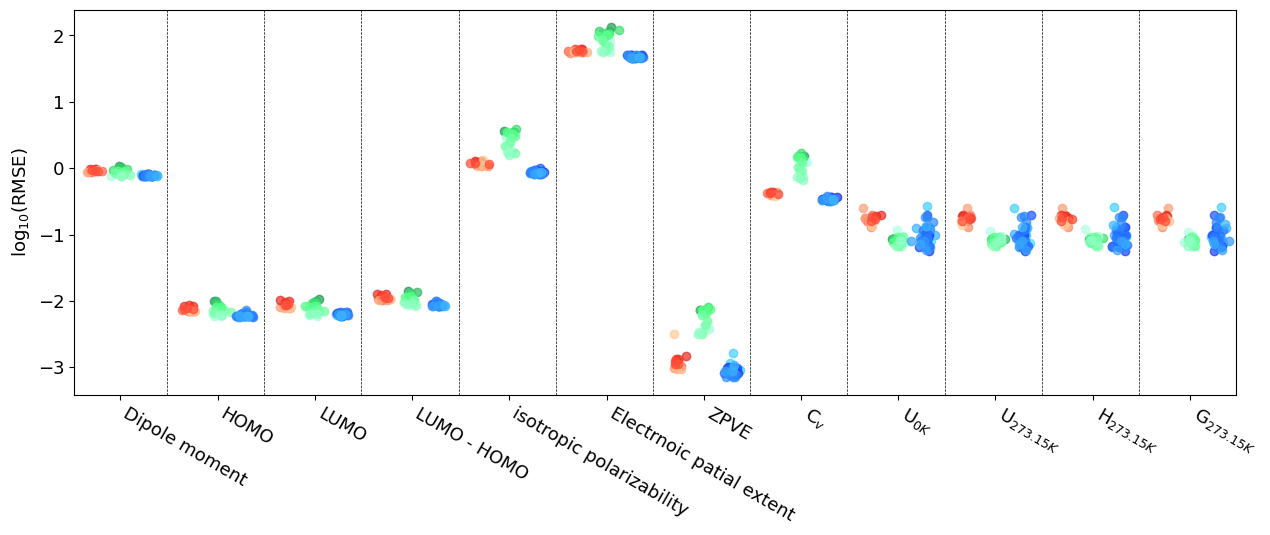

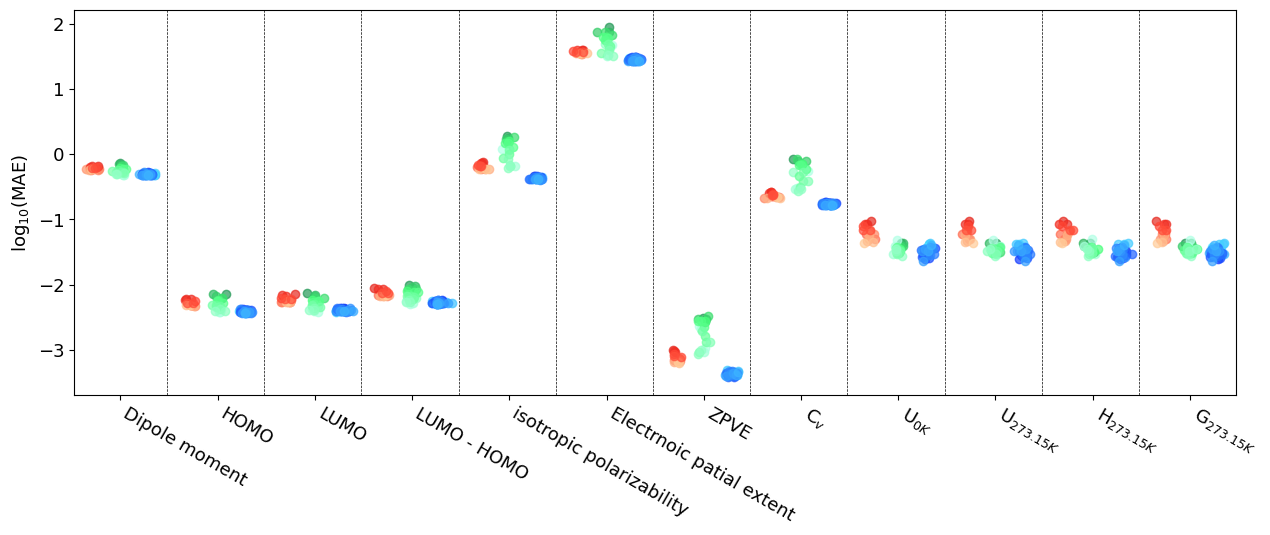

In [5]:
xlbls = ["Dipole moment","HOMO","LUMO","LUMO - HOMO","isotropic polarizability","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
for i, (metric, err) in enumerate(cv_errs['valid'].items()):
    f, ax = plt.subplots(1,1,figsize=(15,5))
    ys = np.array([np.mean(e[0], axis=1) for e in err])
    ys = np.hstack([ys[:,0:1], ys[:, 2:5], ys[:, 1:2], ys[:,5:]])
    lbls = np.array([e[1] for e in err])
    size = np.array([float(l.split('_')[4]) for l in lbls])
    x = np.linspace(0, 23, 12)
    minmax = {m[0]:[np.min([s for s, l in zip(size, lbls) if l.startswith(m)]), np.max([s for s, l in zip(size, lbls) if l.startswith(m)])] for m in ['graph','mol','concat']}
    for y, l, s in zip(ys, lbls, size):
        vmin, vmax = minmax[l[0]]
        scale = 0.8 * (np.log10(s) - np.log10(vmin))/(np.log10(vmax)  - np.log10(vmin)) + 0.2
        if l.startswith('mol'):
            ax.scatter(x-0.6+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Global state', color=cmap1(scale), alpha=0.7)
        elif l.startswith('graph'):
            ax.scatter(x+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Graph feature', color=cmap2(scale), alpha=0.7)
        elif l.startswith('concat'):
            ax.scatter(x+0.6+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Mixed', color=cmap3(scale), alpha=0.7)
    ax.set_xticks(x, labels=xlbls, rotation=-30, ha='left')
    ax.set_xlim([-1, 24])
    ax.set_ylabel('R$^2$-score' if i == 0 else 'log$_{10}$'+f'({metric.upper()})')
    for ix in x: ax.axvline(ix+1, color=[0,0,0], lw=0.5, ls='--')
f.subplots_adjust(hspace=0.5)

In [117]:
maes = np.array([np.mean(e[0], axis=1) for e in cv_errs['valid']['mae']])
r2s = np.array([np.mean(e[0], axis=1) for e in cv_errs['valid']['r2']])
lbls = [e[1] for e in cv_errs['valid']['mae']]
#score_r2  = np.sum((r2s - r2s.min(axis=0))/(r2s.max(axis=0) - r2s.min(axis=0)), axis=1)
#score_mae = np.sum((maes - maes.min(axis=0))/(maes.max(axis=0) - maes.min(axis=0)), axis=1)
score_r2  = np.sum(r2s/r2s.max(axis=0), axis=1)
score_mae = np.sum(maes/maes.min(axis=0), axis=1)

rank_mae = score_mae.argsort().argsort()
rank_r2 = score_r2.shape[0] - score_r2.argsort().argsort() - 1
data = {
    'mae/rank':rank_mae, 'mae/score':score_mae, 'r2/rank':rank_r2, 'r2/score':score_r2,
}
data.update({f'mae/{xlb}':v for xlb, v in zip(xlbls, np.array(maes).T)})
data.update({f'r2/{xlb}':v for xlb, v in zip(xlbls, np.array(r2s).T)})
data.update({f'mae/rank/{xlb}':np.argsort(v).argsort() for xlb, v in zip(xlbls, np.array(maes).T)})
data.update({f'r2/rank/{xlb}':score_r2.shape[0] - np.argsort(v).argsort() - 1 for xlb, v in zip(xlbls, np.array(r2s).T)})
data.update({
    'graph/node' :[int(l.split('_')[2].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    'graph/layer':[int(l.split('_')[3].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    'mol/node' :[int(l.split('_')[2].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    'mol/layer':[int(l.split('_')[3].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    'global/param':[int(float(l.split('_')[4])) for l in lbls],
    'global/label':lbls,
    
    })
df = pd.DataFrame(data)
scores = df[['r2/score','mae/score']].values
norm = (scores - scores.min(axis=0)) / (scores.max(axis=0) - scores.min(axis=0))
df['global/score'] = norm.T[1] - norm.T[0]
df['global/rank'] = np.argsort(norm.T[1] - norm.T[0]).argsort()

pd.set_option('display.max_colwidth', 12)
df.sort_values('r2/rank')[:20]['global/label'].values
#df.sort_values('mae/rank')[:20]['global/label'].values
#df.sort_values('global/rank')[:20]['global/label'].values

array(['concat_cg_64.128_6.2_195072', 'concat_cg_64.256_6.1_283136',
       'concat_cg_64.256_8.1_317440', 'concat_cg_128.128_4.2_364224',
       'concat_cg_128.256_4.1_452288', 'concat_cg_64.256_8.2_383232',
       'concat_cg_64.128_6.1_178560', 'concat_cg_64.128_6.3_211584',
       'concat_cg_64.256_4.1_248832', 'concat_cg_64.128_8.1_212864',
       'concat_cg_128.256_6.1_586432', 'concat_cg_64.128_4.1_144256',
       'concat_cg_64.128_4.3_177280', 'concat_cg_64.128_4.2_160768',
       'concat_cg_128.128_4.1_347712', 'concat_cg_64.128_8.3_245888',
       'concat_cg_64.256_6.2_348928', 'concat_cg_32.256_8.1_214176',
       'concat_cg_32.128_8.1_109600', 'concat_cg_64.256_4.2_314624'],
      dtype=object)

In [151]:
#df[(df['graph/node'] == 64) & (df['graph/layer'] == 4)].T
#df[df['graph/node' == 0]].sort_values('mae/rank').T
#df[df['mol/node' == 0]].sort_values('mae/rank').T
df[df['mol/layer'] == 0].sort_values('r2/rank').T
df.sort_values('r2/rank').T

64           71           73           36           41  \
mae/rank               19           15           22           13           17   
mae/score        13.91736     13.83806    14.180368    13.714282    13.858632   
r2/rank                 0            1            2            3            4   
r2/score        11.997142    11.995725    11.987998    11.986481    11.979842   
mae/Dipol...     0.475961     0.475874     0.479459     0.482902     0.490425   
mae/isotr...     0.413212     0.410204     0.416322     0.414056     0.418088   
mae/HOMO         0.003726     0.003742      0.00376     0.003734     0.003856   
mae/LUMO         0.003865     0.003919     0.003916     0.003886     0.003995   
mae/LUMO ...      0.00507     0.005142     0.005147     0.005113     0.005291   
mae/Elect...     27.29936    27.207461    26.995855    27.385069    27.139141   
mae/ZPVE         0.000433     0.000421     0.000436     0.000406     0.000415   
mae/C$_v$        0.166153     0.164887     0.167454     0.164986     0.166783   
mae/U$_{0K}$     0.033665     0.033298     0.034852     0.032693     0.032685   
mae/U$_{2...     0.033647      0.03329     0.034863     0.032729     0.032683   
mae/H$_{2...     0.033648     0.033281     0.034855     0.032718     0.032708   
mae/G$_{2...     0.033647     0.033297     0.034868     0.032726     0.032672   
r2/Dipole...     0.755877     0.756491     0.752926     0.749875     0.747737   
r2/isotro...     0.989572     0.989322     0.989406      0.98835     0.989405   
r2/HOMO          0.931419     0.930691     0.928832     0.931557     0.928201   
r2/LUMO          0.983715     0.983291     0.983414     0.983664     0.982987   
r2/LUMO -...     0.969154     0.968449     0.968579     0.969373     0.967828   
r2/Electr...     0.972658     0.972875     0.972995     0.973096     0.973231   
r2/ZPVE          0.999364     0.999265     0.999109     0.998908      0.99923   
r2/C$_v$         0.993589     0.993501     0.992125     0.992996     0.993323   
r2/U$_{0K}$      0.999774     0.999756      0.99977     0.999474     0.999526   
r2/U$_{27...     0.999774     0.999757      0.99977     0.999445     0.999525   
r2/H$_{27...     0.999774     0.999756      0.99977     0.999489     0.999525   
r2/G$_{27...     0.999774     0.999756      0.99977     0.999476     0.999525   
mae/rank/...            1            0            3            8           18   
mae/rank/...            2            0            8            5           10   
mae/rank/...            1            6            7            3           16   
mae/rank/...            2            8            7            3           17   
mae/rank/...            0            6            8            4           19   
mae/rank/...            5            3            0            7            2   
mae/rank/...           18           15           22            6            9   
mae/rank/...            2            0            6            1            3   
mae/rank/...           34           31           38           26           25   
mae/rank/...           33           31           38           27           25   
mae/rank/...           33           31           38           27           26   
mae/rank/...           33           31           38           27           25   
r2/rank/D...            1            0            3            6            8   
r2/rank/i...            3            7            4           23            5   
r2/rank/HOMO            1            2            5            0            6   
r2/rank/LUMO            1            6            5            2           13   
r2/rank/L...            1            4            3            0           10   
r2/rank/E...            9            6            5            2            0   
r2/rank/ZPVE            8           15           30           39           17   
r2/rank/C...            0            2           32           16            7   
r2/rank/U...           18           23           19   

In [150]:
maes = np.array([np.mean(e[0], axis=1) for e in cv_errs['valid']['mae']])
r2s = np.array([np.mean(e[0], axis=1) for e in cv_errs['valid']['r2']])
err_maes = np.array([np.std(e[0], axis=1) for e in cv_errs['valid']['mae']])
err_r2s = np.array([np.std(e[0], axis=1) for e in cv_errs['valid']['r2']])
i1 = 64
i2 = 70
fps = ['{:.4f}', '{:.4f}', '{:.6f}', '{:.6f}', '{:.6f}', '{:.2f}', '{:.7f}', '{:.4f}', '{:.5f}', '{:.5f}', '{:.5f}', '{:.5f}',]
for xlbl, mae, mae_err, r2, r2_err, fp in zip(xlbls, maes.T, err_maes.T, r2s.T, err_r2s.T, fps):
    i3 = np.argmin(mae)
    i4 = np.argmax(r2)
    fmt = '{:25s} /' + '//'.join([fp + '±' + fp + '/{:.4f}±{:.4f}']*3)
    #print('{:25s} / {:12.3f}±{:.3f} / {:.4f}±{:.4f} // {}±{} / {:.4f}±{:.4f} // {}±{} / {:.4f}±{:.4f}'.format(
    print(fmt.format(
        xlbl, mae[i1], mae_err[i1], r2[i1], r2_err[i1],
        mae[i2], mae_err[i2], r2[i2], r2_err[i2],
        mae[i3], mae_err[i3], r2[i4], r2_err[i4],
        ))

Dipole moment             /0.4760±0.0118/0.7559±0.0121//0.5010±0.0095/0.7349±0.0103//0.4759±0.0047/0.7565±0.0052
isotropic polarizability  /0.4132±0.0138/0.9896±0.0039//0.4344±0.0104/0.9888±0.0039//0.4102±0.0079/0.9898±0.0036
HOMO                      /0.003726±0.000096/0.9314±0.0052//0.003961±0.000078/0.9243±0.0044//0.003721±0.000053/0.9316±0.0033
LUMO                      /0.003865±0.000124/0.9837±0.0008//0.004112±0.000072/0.9822±0.0008//0.003815±0.000046/0.9839±0.0005
LUMO - HOMO               /0.005070±0.000172/0.9692±0.0025//0.005448±0.000086/0.9660±0.0020//0.005070±0.000172/0.9694±0.0021
Electrnoic patial extent  /27.30±0.40/0.9727±0.0008//28.50±0.86/0.9710±0.0011//27.00±0.77/0.9732±0.0011
ZPVE                      /0.0004330±0.0000206/0.9994±0.0004//0.0003951±0.0000167/0.9992±0.0007//0.0003777±0.0000204/0.9995±0.0000
C$_v$                     /0.1662±0.0037/0.9936±0.0011//0.1725±0.0039/0.9931±0.0010//0.1649±0.0016/0.9936±0.0011
U$_{0K}$                  /0.03367±0.00025/0.9998±0

In [86]:
maes = np.array([e[0] for e in fin_errs['test']['mae']])
r2s = np.array([e[0] for e in fin_errs['test']['r2']])
lbls = [e[1] for e in fin_errs['test']['mae']]
score_r2  = np.sum(r2s/r2s.max(axis=0), axis=1)
#score_r2  = np.sum((r2s - r2s.min(axis=0))/(r2s.max(axis=0) - r2s.min(axis=0)), axis=1)
score_mae = np.sum(maes/maes.min(axis=0), axis=1)
#score_mae = np.sum((maes - maes.min(axis=0))/(maes.max(axis=0) - maes.min(axis=0)), axis=1)

rank_mae = score_mae.argsort().argsort()
rank_r2 = score_r2.shape[0] - score_r2.argsort().argsort() - 1
data = {
    'mae/rank':rank_mae, 'mae/score':score_mae, 'r2/rank':rank_r2, 'r2/score':score_r2,
}
data.update({f'mae/{xlb}':v for xlb, v in zip(xlbl, np.array(maes).T)})
data.update({f'r2/{xlb}':v for xlb, v in zip(xlbl, np.array(r2s).T)})
data.update({
    f'graph/node' :[int(l.split('_')[2].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    f'graph/layer':[int(l.split('_')[3].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    f'mol/node' :[int(l.split('_')[2].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    f'mol/layer':[int(l.split('_')[3].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    f'global/param':[int(l.split('_')[4]) for l in lbls],
    f'global/label':lbls,
    })
dff = pd.DataFrame(data)
scores = dff[['r2/score','mae/score']].values
norm = (scores - scores.min(axis=0)) / (scores.max(axis=0) - scores.min(axis=0))
dff['global/score'] = norm.T[1] - norm.T[0]
dff['global/rank'] = np.argsort(norm.T[1] - norm.T[0]).argsort()

pd.set_option('display.max_colwidth', 12)
dff.sort_values('r2/rank')[:20]['global/label'].values
#dff.sort_values('mae/rank')[:20]['global/label'].values
#dff.sort_values('global/rank')[:20]['global/label'].values

array(['concat_cg_64.128_8.3_245888', 'concat_cg_64.128_8.2_229376',
       'concat_cg_64.256_8.1_317440', 'concat_cg_128.256_4.1_452288',
       'concat_cg_64.256_6.1_283136', 'concat_cg_128.128_6.1_481856',
       'concat_cg_128.128_4.3_380736', 'concat_cg_64.256_6.2_348928',
       'concat_cg_64.128_6.2_195072', 'concat_cg_128.256_6.1_586432',
       'concat_cg_64.128_6.1_178560', 'concat_cg_64.128_4.1_144256',
       'concat_cg_128.128_4.1_347712', 'concat_cg_64.256_4.1_248832',
       'concat_cg_64.128_6.3_211584', 'concat_cg_128.128_6.3_514880',
       'concat_cg_64.128_4.3_177280', 'concat_cg_64.128_8.1_212864',
       'concat_cg_32.128_8.1_109600', 'graph_cg_128_6_410016'],
      dtype=object)

[64, 70]


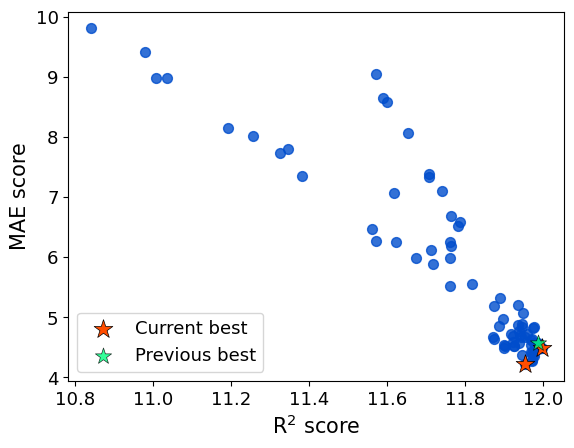

In [10]:
ii = [np.argmax(score_r2), np.argmin(score_mae)]
print(ii)
plt.scatter(score_r2, score_mae, color=[0,0.3,0.8], alpha=0.8, s=50)
plt.scatter(score_r2[ii], score_mae[ii], color=[1,0.3,0], marker='*', s=200, edgecolor=[0,0,0], lw=0.5, label='Current best')
plt.scatter(score_r2[-2], score_mae[-2], color=[0,1,0.5], marker='*', s=150, alpha=0.8, edgecolors=[0,0,0], lw=0.5, label='Previous best')

plt.ylabel('MAE score', fontsize=15)
plt.xlabel('R$^2$ score', fontsize=15)
plt.legend(loc='lower left')

In [26]:
tags = [v[1] for v in cv_errs['valid']['r2']]
cv_r2s = np.array([v[0] for v in cv_errs['valid']['r2']])
cv_maes = np.array([v[0] for v in cv_errs['valid']['mae']])

In [25]:
xlbl

['Dipole moment',
 'Isotropic polarizability',
 'HOMO',
 'LUMO',
 'LUMO - HOMO',
 'Electrnoic patial extent',
 'ZPVE',
 'C$_v$',
 'U$_{0K}$',
 'U$_{273.15K}$',
 'H$_{273.15K}$',
 'G$_{273.15K}$']

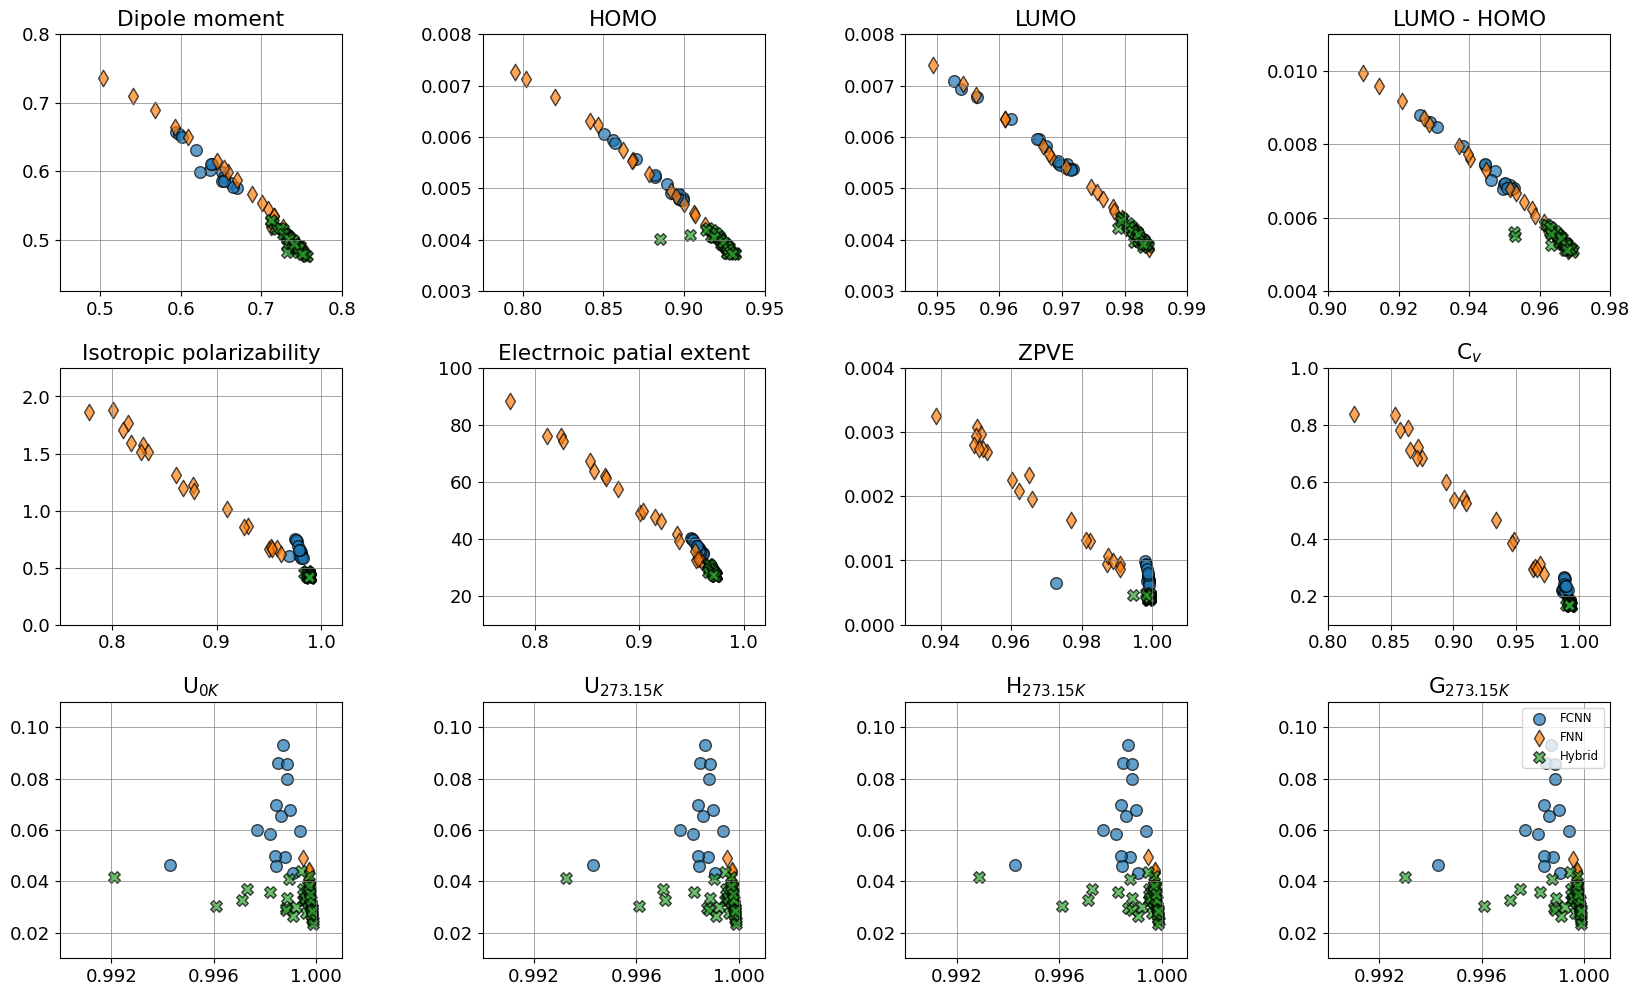

In [99]:
f, axs = plt.subplots(3,4,figsize=(20,12))
xlbls = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
order = [0,2,3,4,1,5,6,7,8,9,10,11]
labels = {'mol':'FCNN','graph':'FNN','concat':'Hybrid'}
marker = {'mol':'o','graph':'d','concat':'X'}

for i, ax in zip(order, axs.reshape(-1)):
    for g in ['mol','graph','concat']:
        m = [g in t for t in tags]
        x = cv_r2s[m][:, i].mean(-1)
        y = cv_maes[m][:, i].mean(-1)
        ax.scatter(x, y, label=labels[g], marker=marker[g], s=70, alpha=0.7, edgecolors=[0,0,0])
    ax.set_title(xlbls[i])
ax.legend(loc='upper right', fontsize=8.5)
lims = [
    [[0.45, 0.8], [0.425, 0.8], None, None],
    [[0.775, 0.95], [0.003, 0.008], None, [0.003+i*0.001 for i in range(6)]],
    [[0.945, 0.99], [0.003, 0.008], None, [0.003+i*0.001 for i in range(6)]],
    [[0.9, 0.98], [0.004, 0.011], None, [0.004+i*0.002 for i in range(4)]],
    
    [[0.75, 1.02], [0, 2.25], [0.8+i*0.1 for i in range(3)], None],
    [[0.75, 1.02], [10, 100], [0.8+i*0.1 for i in range(3)], [20+i*20 for i in range(5)]],
    [[0.93, 1.01], [0, 0.004], None, [0+i*0.001 for i in range(5)]],
    [[0.8, 1.025], [0.1, 1.0], None, [0.2+i*0.2 for i in range(5)]],
    
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],

    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
]
for ax, (xlim, ylim, xticks, yticks) in zip(axs.reshape(-1), lims):
    ax.set_xlim(xlim)
    if xticks is not None: ax.set_xticks(xticks)
    ax.set_ylim(ylim)
    if yticks is not None: ax.set_yticks(yticks)
    ax.grid('on', color=[0.5,0.5,0.5], lw=0.5)
f.subplots_adjust(hspace=0.3, wspace=0.5)
f.savefig('./figs/output.pretrain.all.pdf')

In [132]:
df0 = pd.read_csv('./data/fpolymers_221123.csv')
df1 = pd.read_csv('./data/fpolymers_230823.csv')
df2 = pd.concat([
    pd.read_csv('./data/fpolymers_230823.tg.train.csv'),
    pd.read_csv('./data/fpolymers_230823.tg.test.csv')
])
df0.columns

Index(['ID', 'Name', 'CAS_A', 'CAS_B', 'CAS_C', 'CAS_D', 'CAS_E', 'SMILES_A',
       'SMILES_B', 'SMILES_C', 'SMILES_D', 'SMILES_E', 'FR_A', 'FR_B', 'FR_C',
       'FR_D', 'FR_E', 'ES', 'DC', 'TG', 'MW', 'TGA_0.01'],
      dtype='object')

In [130]:
df0.shape, df1.shape

((336, 22), (335, 54))

In [185]:
#tgids = df1.ID[(~df1.DSC_Tg.isna())]
#excid = tgids[~tgids.isin(df2.ID)]
#df3 = df1[~df1.ID.isin(excid)].copy()
#df4 = df0[df0.ID.isin(df3.ID)]
#df5 = df4[~df4.MW.isna()]
#df3[df3.ID.isin(df5.ID)]
#df1.loc[df1.ID.isin(df0.ID), 'MW'] = df0.loc[df0.ID.isin(df1.ID), 'MW']
#df1 = df1[['ID', 'Name', 'A', 'B', 'C', 'D', 'E', 'SMILES_A', 'SMILES_B',
#       'SMILES_C', 'SMILES_D', 'SMILES_E', 'FR_A', 'FR_B', 'FR_C', 'FR_D',
#       'FR_E', 'MW', 'SE', 'DC', 'DSC_Tg', 'TGA 1% loss (degC)', 'Unnamed: 21',
#       'REF_ID', 'REF_NAME', 'REF_A', 'REF_B', 'REF_C', 'REF_D', 'REF_E',
#       'REF_FRA', 'REF_FRB', 'REF_FRC', 'REF_FRC.1', 'REF_FRD', 'REF_FRE',
#       'REF_DC', 'REF_DSC_TG', 'REF TGA 1% loss (degC)', 'Unnamed: 38',
#       'CHECK_ID', 'CHECK_Sa', 'CHECK_SB', 'CHECK_SC', 'CHECK_SD', 'CHECK_SE',
#       'CHECK_FA', 'CHECK_FB', 'CHECK_FC', 'CHECK_FD', 'CHECK_FE',
#       'CHECK_SE.1', 'CHECK_DSC', 'CHECK_TG', 'CHECK_TGA', ]]
(~df1[~df1.ID.isin(excid)].MW.isna()).sum()

300

In [192]:
df1[((df1[[f'SMILES_{x}' for x in 'ABCDE']] == 'O=C1N(OC(=O)C(=C)C)C(=O)CC1').sum(1) != 0)]

ID                Name           A           B        C        D  \
107  FA-00237  0086_PF/SUIMA-CO-3  45115-53-5  38862-25-8  80-62-6  79-41-4   
161  FA-00297    87_PF/SUIMA-CO-1  45115-53-5  38862-25-8  80-62-6  79-41-4   
221  FA-00361       163_SUIMA_442  45115-53-5  38862-25-8  80-62-6  79-41-4   
301  FA-00452    85_PF-SUIMA-CO-5  45115-53-5  38862-25-8  80-62-6  79-41-4   

            E                      SMILES_A                     SMILES_B  \
107  868-77-9  CC(=C)C(=O)OCC(C(F)(F)F)(F)F  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
161  868-77-9  CC(=C)C(=O)OCC(C(F)(F)F)(F)F  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
221  868-77-9  CC(=C)C(=O)OCC(C(F)(F)F)(F)F  O=C1N(OC(=O)C(=C)C)C(=O)CC1   
301  868-77-9  CC(=C)C(=O)OCC(C(F)(F)F)(F)F  O=C1N(OC(=O)C(=C)C)C(=O)CC1   

          SMILES_C  ... CHECK_SE CHECK_FA  CHECK_FB  CHECK_FC  CHECK_FD  \
107  COC(=O)C(C)=C  ...                                                   
161  COC(=O)C(C)=C  ...                                                   
221  COC(=O)C(C)=C  ...                                                   
301  COC(=O)C(C)=C  ...                                                   

     CHECK_FE  CHECK_SE.1  CHECK_DSC  CHECK_TG  CHECK_TGA  
107                                                        
161                                                        
221                                                        
301                                                        

[4 rows x 55 columns]

- legacy encoders

In [ ]:
import torch
scores = {}

for i in [1,2,3,4,5,6,7,8,9]:
    root = f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_{i}'
    nets = ['mol/dnn','graph/cg','concat/cg']
    for net in nets:
        path = os.path.join(root, net)
        if not os.path.isdir(path): continue
        output = get_output(path, '', fmt='cv_{:04d}', epoch='00500')
        model = torch.load(os.path.join(root, net, 'cv_0000', '00500.model.torch'), map_location='cpu')
        n = 0
        for k, v in model.items():
            if 'decoder' in k: continue
            n += np.prod(v.numpy().shape)
        p = json.load(open(os.path.join(root, net, 'cv_0000/param.json')))
        ng1 = p['encoder_params']['graph_net_params']['hidden_dim']
        ng2 = p['encoder_params']['graph_net_params']['n_layer']
        nm1 = p['encoder_params']['mol_net_params']['hidden_dim']
        nm2 = p['encoder_params']['mol_net_params']['n_layer']
        if net.startswith('graph'):
            k = net.split('/')[0] + f'_{n:.0f}_{i}_{ng1}/{ng2/2:.0f}'
        elif net.startswith('mol'):
            k = net.split('/')[0] + f'_{n:.0f}_{i}_{nm1}/{nm2}'
        else:
            k = net.split('/')[0] + f'_{n:.0f}_{i}_{nm1}/{nm2}/{ng1}/{ng2/2:.0f}'
        scores[k] = output

In [ ]:
f, axs = plt.subplots(12,3,figsize=(15,30))
metric = 'R2'
cmap = plt.get_cmap('tab20c')
for i, net in enumerate(['mol','graph']):#,'graph','concat']):
    for k, v in scores.items():
        if net not in k: continue
        x = int(k.split('_')[1])
        im = int(k.split('_')[2])-1
        nh, nl = [int(n) for n in k.split('_')[3].split('/')]
        for j, (ds, data) in enumerate(v.items()):
            vals = []
            for _, ts, ps in data:
                val = []
                for h, (t, p) in enumerate(zip(ts.T, ps.T)):
                    if metric == 'R2':
                        e = r2_score(t, p)
                    elif metric == 'MAE':
                        e = mean_absolute_error(t, p)
                    elif metric == 'RMSE':
                        e = np.sqrt(mean_squared_error(t, p))
                    else:
                        raise ValueError('not supp metric')
                    val.append(e)
                vals.append(val)
            for l, val in enumerate(np.array(vals).T):
                axs[l, j].scatter([nh+5*(i*4+nl-1)]*len(val), val, color=cmap(i*4+nl-1))
#for ax in axs.reshape(-1):
#    ax.set_xscale('log')
#    ax.set_xlim([1e4, 1e6])
#   ax.set_ylim([0.95, 1.05])
    

- File making / pretrain


In [ ]:
gns = [32, 64, 128]
gls = [4, 6, 8]
mns = [128, 256]
mls = [1, 2 ,3]

param_g = {
        'tag':'cg',
        'encoder_type':'graph',
        'graph_net_params':{
            'graph':'cg',
            'hidden_dim':0,
            'output_dim':32,
            'n_layer':0
        }
    }

param_m = {
    'tag':'dnn',
    'encoder_type':'mol',
    'mol_net_params':{
        'hidden_dim':0,
        'output_dim':32,
        'n_layer':0
    }
}

param_c = {
        'tag':'cg',
        'encoder_type':'concat',
        'graph_net_params':{
            'graph':'cg',
            'hidden_dim':0,
            'output_dim':32,
            'n_layer':0
        },
        'mol_net_params':{
            'hidden_dim':0,
            'output_dim':32,
            'n_layer':0
        }
    }

for gn in gns:
    for gl in gls:
        if gn == 128 and gl == 8: continue
        for mn in mns:
            for ml in mls:
                if mn == 256 and ml == 3: continue
                # graph
                p = param_g.copy()
                p.update({'tag':f'cg_{gl:02d}_{gn}'})
                p['graph_net_params'].update({'hidden_dim':gl, 'n_layer':gn})
                with open(f'params/pretrain/graph/cg_{gl:02d}_{gn}.json','w') as f:
                    json.dump(p, f, indent=4)

                # mol                
                p = param_m.copy()
                p.update({'tag':f'dnn_{mn:02d}_{ml}'})
                p['mol_net_params'].update({'hidden_dim':mn, 'n_layer':ml})
                with open(f'params/pretrain/mol/dnn_{mn:03d}_{ml}.json','w') as f:
                    json.dump(p, f, indent=4)
                    
                # concat
                p = param_c.copy()
                p.update({'tag':f'cg_{gn:02d}.{mn:03d}_{gl}.{ml}'})
                p['graph_net_params'].update({'hidden_dim':gn, 'n_layer':gl})
                p['mol_net_params'].update({'hidden_dim':mn, 'n_layer':ml})      
                with open(f'params/pretrain/concat/cg_{gn:02d}.{mn:03d}_{gl}.{ml}.json','w') as f:
                    json.dump(p, f, indent=4)